In [1]:
import torch.nn as nn
import torch
import numpy as np

import matplotlib.pyplot as plt


import sys
sys.path.append('..')

from opt import graph_id, graph_id_rew
import sev_filters_opt
from data import gen_data, gen_data_sev_H, ER, pert_S

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GNN

In [3]:
class GCNLayer(nn.Module):
    def __init__(self, Spow, h, in_dim, out_dim):
        super().__init__()
        self.Spow = Spow
        self.N = self.Spow.shape[1]
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.h = h
        self.K = self.h.shape[0]
        assert self.Spow.shape[0] == self.K
        
        self.W = nn.Parameter(torch.empty((self.in_dim, self.out_dim)))
        torch.nn.init.kaiming_uniform_(self.W.data)

    def forward(self, x):
        if x.ndim == 3:
            _, Nin, Fin = x.shape
        else:
            Nin, Fin = x.shape
        assert Nin == self.N
        assert Fin == self.in_dim

        H = torch.sum(self.h[:,None,None]*self.Spow, 0)
        return H @ x @ self.W

class GCN(nn.Module):
    def __init__(self, S, in_dim, hid_dim, out_dim, n_layers, K):
        super().__init__()
        self.S = S
        self.N = self.S.shape[0]
        self.K = K

        self.h = nn.Parameter(torch.ones(self.K))

        self.Spow = self.calc_Spow(self.S)

        self.n_layers = n_layers
        self.convs = nn.ModuleList()

        self.convs.append(GCNLayer(self.Spow, self.h, in_dim, hid_dim))

        if n_layers > 1:
            for i in range(n_layers - 2):
                self.convs.append(GCNLayer(self.Spow, self.h, hid_dim, hid_dim))
            self.convs.append(GCNLayer(self.Spow, self.h, hid_dim, out_dim))

    def forward(self, x):

        for i in range(self.n_layers - 1):
            x = torch.tanh(self.convs[i](x))
        x = self.convs[-1](x)

        return x

    def calc_Spow(self, newS):
        Spow = torch.zeros((self.K, self.N, self.N), device=newS.device)
        Spow[0,:,:] = torch.eye(self.N, device=newS.device)
        for k in range(1, self.K):
            Spow[k,:,:] = Spow[k-1,:,:] @ newS
        return Spow

    def update_Spow(self, S):
        self.S = S
        self.N = S.shape[0]
        self.Spow = self.calc_Spow(S)
        for i in range(self.n_layers):
            self.convs[i].Spow = self.Spow

# Training methods

In [4]:
lr = 1e-2
wd = 0
n_epochs = 50
n_layers = 3
hid_dim = 128
eval_freq = 50

In [5]:
def test_reg(model, S, x_train, y_train, n_epochs=n_epochs, lr=lr, wd=wd, x_test=None, y_test=None, verbose=True):

    global gamma

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = nn.MSELoss()

    loss_train, loss_test = [np.zeros(n_epochs) for _ in range(2)]

    for i in range(n_epochs):
        y = model(x_train).squeeze()
        loss = loss_fn(y, y_train)

        assert y.shape[1] == S.shape[0]

        # Commutativity term
        #loss += gamma*((model.H @ S - S @ model.H)**2).sum()

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_train[i] = loss.cpu().item()

        if (i == 0 or (i+1) % eval_freq == 0) and verbose and (x_test is not None):
            with torch.no_grad():
                y_hat = model(x_test).T
                loss_test = loss_fn(y_hat, y_test.T)
            print(f"Epoch {i+1}/{n_epochs} - Loss train: {loss.cpu().item()} - Loss: {loss_test.cpu().item()}", flush=True)
        elif (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss train: {loss.cpu().item()}", flush=True)

    return loss_train, loss_test

In [6]:
def test_clas(model, graph, x, labels, n_epochs=n_epochs, lr=lr, wd=wd, train_idx=[], val_idx=[], test_idx=[], verbose=True):

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = nn.CrossEntropyLoss()

    acc_train, acc_val, acc_test, losses = [np.zeros(n_epochs) for _ in range(4)]

    gamma = 0.1

    for i in range(n_epochs):
        y = model(x)
        loss = loss_fn(y[train_idx], labels[train_idx])

        # Commutativity term
        #loss += gamma*((model.H @ graph - graph @ model.H)**2).sum()

        opt.zero_grad()
        loss.backward()
        opt.step()

        preds = torch.argmax(y, 1)
        results = (preds == labels).type(torch.float32)
        acc_train[i] = results[train_idx].mean().item()
        acc_val[i] = results[val_idx].mean().item()
        acc_test[i] = results[test_idx].mean().item()
        losses[i] = loss.item()

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss: {loss.item()} - Train Acc: {acc_train[i]} - Test Acc: {acc_test[i]}", flush=True)

    return acc_train, acc_val, acc_test, losses

# Data generation

In [7]:
N = 20
M = 50
g_params = {'type': ER, 'p': 0.2}
p_n = 0.1
eps = 0.15
K = 4

In [8]:
X, Y, Cy, Cy_samp, H, S, Sn, h = gen_data(N, M, g_params, p_n, eps, norm_H=True, norm_S=True)

In [9]:
X = torch.Tensor(X).to(device)
Y = torch.Tensor(Y).to(device)

In [10]:
H_ten = torch.Tensor(H.copy()).to(device)
W1 = torch.randn(1,32).to(device)
W2 = torch.randn(32,32).to(device)
W3 = torch.randn(32,1).to(device)

X = X.T[:,:,None]
z1 = torch.tanh(H_ten @ X @ W1)
z2 = torch.tanh(H_ten @ z1 @ W2)
Y = (H_ten @ z2 @ W3).squeeze()
X.shape, Y.shape

(torch.Size([50, 20, 1]), torch.Size([50, 20]))

# Model creation and evaluation

In [11]:
in_dim = 1
out_dim = 1

In [12]:
lambd, gamma, delta, inc_gamma = [5e-4, 1e-4, 10., 1.]
gamma = 1e-3

In [13]:
n_iters = 20

S_id = Sn
H_id = Sn
Ws = None

S_gcn = torch.Tensor(S_id).to(device)
gcn_model = GCN(S_gcn, in_dim, hid_dim, out_dim, n_layers, K).to(device)

gcn_ignore = GCN(S_gcn, in_dim, hid_dim, out_dim, n_layers, K).to(device)
loss_train_ignore, loss_test_ignore = test_reg(gcn_ignore, S_gcn, X, Y, n_epochs=n_epochs*n_iters, verbose=False)

loss_train = np.zeros((n_iters, n_epochs))
loss_test = np.zeros((n_iters, n_epochs))

for i in range(n_iters):
    #print("**************************************")
    print(f"************ Iteration {i} ***********", end="")
    #print("**************************************")

    S_gcn = torch.Tensor(S_id).to(device)

    gcn_model.update_Spow(S_gcn)
    
    # Filter estimation
    #gcn_model = GCN(S_gcn, in_dim, hid_dim, out_dim, n_layers, K).to(device)
    #gcn_model.h.data = h_id
    loss_train[i,:], loss_test[i,:] = test_reg(gcn_model, S_gcn, X, Y, verbose=False)

    h_id = gcn_model.h.data
    H_id = torch.sum(h_id[:,None,None]*gcn_model.Spow, 0).cpu().numpy()

    #print("Graph identification")
    # Graph estimation
    S_id = graph_id(Sn, H_id, Cy, lambd, gamma, delta)

    err_h = ((h - h_id.cpu().numpy())**2).sum()
    err_H = ((H - H_id)**2).sum()
    err_S = ((S - S_id)**2).sum()
    print(f"Stats: {err_h=} - {err_H=} - {err_S=} - {loss_train[i,-1]=}")
    #print()

************ Iteration 0 ***********Stats: err_h=3.022365774308118 - err_H=37232.65250102717 - err_S=103.54121863428517 - loss_train[i,-1]=2807.2578125
************ Iteration 1 ***********Stats: err_h=2.1854653566646935 - err_H=14.420512275044569 - err_S=0.0011289151576238418 - loss_train[i,-1]=0.06975987553596497
************ Iteration 2 ***********Stats: err_h=2.0088050017811665 - err_H=37305.19729871141 - err_S=0.0011160374152769372 - loss_train[i,-1]=73.75826263427734
************ Iteration 3 ***********Stats: err_h=1.3781352022019733 - err_H=22096.429739837753 - err_S=0.001108467337071504 - loss_train[i,-1]=122.8288345336914
************ Iteration 4 ***********Stats: err_h=0.9852624372439733 - err_H=10408.05247908425 - err_S=0.0011058687123082403 - loss_train[i,-1]=26.957618713378906
************ Iteration 5 ***********Stats: err_h=0.7982754457078303 - err_H=3326.716141391356 - err_S=0.001104548508241999 - loss_train[i,-1]=30.21657371520996
************ Iteration 6 ***********Stat

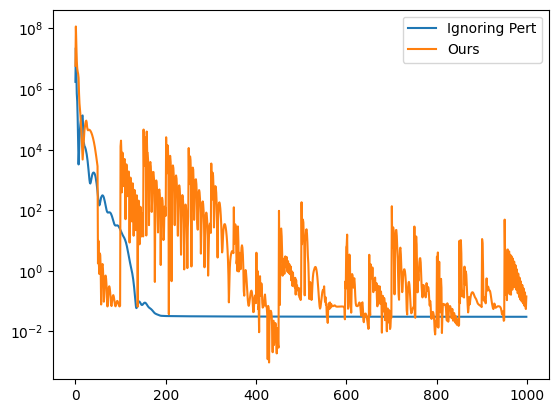

In [14]:
plt.semilogy(loss_train_ignore, label="Ignoring Pert")
plt.semilogy(loss_train.reshape(-1), label="Ours")
plt.legend()

# Several filters

In [15]:
class GCNLayerMulti(nn.Module):
    def __init__(self, Spow, K, in_dim, out_dim):
        super().__init__()

        self.Spow = Spow
        self.N = self.Spow.shape[1]
        self.K = K

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.h = nn.Parameter(torch.ones(self.K))
        assert self.Spow.shape[0] == self.K

        self.W = nn.Parameter(torch.empty((self.in_dim, self.out_dim)))
        torch.nn.init.kaiming_uniform_(self.W.data)

    def forward(self, x):
        if x.ndim == 3:
            _, Nin, Fin = x.shape
        else:
            Nin, Fin = x.shape
        assert Nin == self.N
        assert Fin == self.in_dim

        #print(self.h.device, self.Spow.device)
        H = torch.sum(self.h[:,None,None]*self.Spow, 0)
        
        return H @ x @ self.W

In [16]:
class GCNMulti(nn.Module):
    def __init__(self, S, in_dim, hid_dim, out_dim, n_layers, K):
        super().__init__()
        self.S = S
        self.N = self.S.shape[0]
        self.n_layers = n_layers
        self.K = K

        self.Spow = self.calc_Spow(self.S)

        self.convs = nn.ModuleList()

        self.convs.append(GCNLayerMulti(self.Spow, self.K, in_dim, hid_dim))

        if self.n_layers > 1:
            for i in range(self.n_layers - 2):
                self.convs.append(GCNLayerMulti(self.Spow, self.K, hid_dim, hid_dim))
            self.convs.append(GCNLayerMulti(self.Spow, self.K, hid_dim, out_dim))

    def forward(self, x):

        for i in range(self.n_layers - 1):
            x = torch.tanh(self.convs[i](x))
        x = self.convs[-1](x)

        return x

    def calc_Spow(self, newS):
        Spow = torch.zeros((self.K, self.N, self.N), device=newS.device)
        Spow[0,:,:] = torch.eye(self.N, device=newS.device)
        for k in range(1, self.K):
            Spow[k,:,:] = Spow[k-1,:,:] @ newS
        return Spow

    def update_Spow(self, S):
        self.N = S.shape[0]
        self.S = S
        self.Spow = self.calc_Spow(S)
        for i in range(self.n_layers):
            self.convs[i].Spow = self.Spow

In [17]:
def test_reg_multi(model, S, x_train, y_train, n_epochs, x_test=None, y_test=None, verbose=True):

    global gamma

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = nn.MSELoss()

    loss_train, loss_test = [np.zeros(n_epochs) for _ in range(2)]

    for i in range(n_epochs):
        y = model(x_train).squeeze()
        loss = loss_fn(y, y_train)
        
        assert y.shape[1] == S.shape[0]

        # Commutativity term
        # for k in range(model.n_layers):
        #     loss += gamma * (((model.H[k,:,:] @ S - S @ model.H[k,:,:])**2).sum())

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_train[i] = loss.cpu().item()

        if (i == 0 or (i+1) % eval_freq == 0) and verbose and (x_test is not None):
            with torch.no_grad():
                y_hat = model(x_test)
                loss_test = loss_fn(y_hat, y_test)
            print(f"Epoch {i+1}/{n_epochs} - Loss train: {loss.cpu().item()} - Loss: {loss_test.cpu().item()}", flush=True)
        elif (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss train: {loss.cpu().item()}", flush=True)

    return loss_train, loss_test

In [18]:
X, Y, Cy, Cy_samp, Hs, S, Sn, hs = gen_data_sev_H(N, M, n_layers, g_params, p_n, eps, norm_H=True, norm_S=True)

In [19]:
X = torch.Tensor(X[0,:,:]).to(device)
Y = torch.Tensor(Y[0,:,:]).to(device)
Hs_ten = torch.Tensor(Hs.copy()).to(device)

In [20]:
X = X.T[:,:,None]
z = X.clone()
F = [1, 32, 32, 1]
for i in range(1, n_layers+1):
    W = torch.randn(F[i-1], F[i]).to(device)
    z = torch.tanh(Hs_ten[i-1,:,:] @ z @ W)
Y = z.squeeze()
X.shape, Y.shape

(torch.Size([50, 20, 1]), torch.Size([50, 20]))

In [21]:
n_iters = 30

S_id = Sn
H_id = np.array([Sn]*n_layers)
Ws = None

S_gcn = torch.Tensor(S_id).to(device)
gcn_model = GCNMulti(S_gcn, in_dim, hid_dim, out_dim, n_layers, K).to(device)

gcn_ignore = GCNMulti(S_gcn, in_dim, hid_dim, out_dim, n_layers, K).to(device)
loss_train_ignore, loss_test_ignore = test_reg_multi(gcn_ignore, S_gcn, X, Y, n_epochs=n_epochs*n_iters, verbose=False)

loss_train = np.zeros((n_iters, n_epochs))
loss_test = np.zeros((n_iters, n_epochs))

for i in range(n_iters):
    #print("**************************************")
    print(f"************ Iteration {i} ***********", end="")
    #print("**************************************")

    S_gcn = torch.Tensor(S_id).to(device)

    gcn_model.update_Spow(S_gcn)
    
    # Filter estimation
    loss_train[i,:], loss_test[i,:] = test_reg_multi(gcn_model, S_gcn, X, Y, verbose=False)

    h_id = torch.stack([gcn_model.convs[i].h.data for i in range(n_layers)])
    H_id = np.zeros((n_layers, N, N))
    for i in range(n_layers):
        hs = h_id[i,:]
        H_id[i,:,:] = torch.sum(hs[:,None,None]*gcn_model.Spow, 0).cpu().numpy()

    #print("Graph identification")
    # Graph estimation
    S_id = sev_filters_opt.graph_id(Sn, H_id, Cy, lambd, gamma, delta)

    err_h = ((h - h_id.cpu().numpy())**2).sum(1).mean()
    err_H = ((Hs - H_id)**2).sum((1,2)).mean()
    err_S = ((S - S_id)**2).sum()
    print(f" - Stats: {err_h=:5f} - {err_H=:5f} - {err_S=:5f} - {loss_train[i,-1]=:5f}")
    #print()

************ Iteration 0 *********** - Stats: err_h=3.350526 - err_H=41137.846721 - err_S=82.017477 - loss_train[i,-1]=0.000000
************ Iteration 1 *********** - Stats: err_h=2.431183 - err_H=14.541885 - err_S=0.026701 - loss_train[i,-1]=0.000000
************ Iteration 2 *********** - Stats: err_h=2.228304 - err_H=28682.840566 - err_S=0.026573 - loss_train[i,-1]=30.038280
************ Iteration 3 *********** - Stats: err_h=2.070066 - err_H=25209.637562 - err_S=0.026467 - loss_train[i,-1]=30.038280
************ Iteration 4 *********** - Stats: err_h=1.906440 - err_H=22319.424763 - err_S=0.026387 - loss_train[i,-1]=30.038280
************ Iteration 5 *********** - Stats: err_h=1.893138 - err_H=20891.738057 - err_S=0.026310 - loss_train[i,-1]=30.038280
************ Iteration 6 *********** - Stats: err_h=1.928115 - err_H=24624.552787 - err_S=0.026241 - loss_train[i,-1]=30.038280
************ Iteration 7 *********** - Stats: err_h=1.914418 - err_H=23752.652336 - err_S=0.026176 - loss_tr

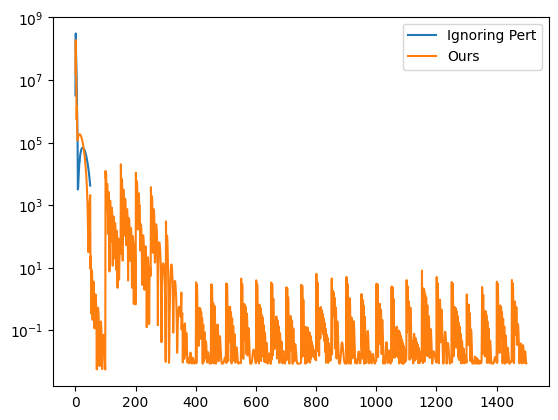

In [22]:
plt.semilogy(loss_train_ignore, label="Ignoring Pert")
plt.semilogy(loss_train.reshape(-1), label="Ours")
plt.legend()

# Karate Club classification

In [23]:
from dgl.data import KarateClubDataset

In [24]:
zach = KarateClubDataset()[0]

labels = zach.ndata['label'].to(device)
S = zach.adj().to_dense()
Sn = pert_S(S, type="rewire", eps=0.1)

N = S.shape[0]
in_dim = 1
out_dim = (torch.max(labels) + 1).item()
out_dim

2

In [25]:
N_train = int(0.5 * N)
idxs = torch.randperm(N)
train_idx = idxs[:N_train]
test_idx = idxs[N_train:]

In [26]:
X = torch.sum(S, 0).to(device)[:,None]
Y = labels
X.shape, Y.shape

(torch.Size([34, 1]), torch.Size([34]))

In [27]:
Cy = np.zeros((N,N))
delta = 0.

In [28]:
n_iters = 20

S_id = Sn
H_id = Sn
Ws = None

S_gcn = torch.Tensor(S_id).to(device)
gcn_model = GCN(S_gcn, in_dim, hid_dim, out_dim, n_layers, K).to(device)

for i in range(n_iters):
    #print("**************************************")
    print(f"************ Iteration {i} ***********", end="")
    #print("**************************************")

    S_gcn = torch.Tensor(S_id).to(device)

    gcn_model.update_Spow(S_gcn)
    
    # Filter estimation
    #gcn_model = GCN(S_gcn, in_dim, hid_dim, out_dim, n_layers, K).to(device)
    #gcn_model.h.data = h_id
    acc_train, acc_val, acc_test, losses = test_clas(gcn_model, S_gcn, X, Y, train_idx=train_idx, test_idx=test_idx, verbose=False)

    h_id = gcn_model.h.data
    H_id = torch.sum(h_id[:,None,None]*gcn_model.Spow, 0).cpu().numpy()

    #print("Graph identification")
    # Graph estimation
    S_id = graph_id(Sn, H_id, Cy, lambd, gamma, delta)

    #err_h = ((h - h_id.cpu().numpy())**2).sum()
    #err_H = ((H - H_id)**2).sum()
    err_S = ((S - S_id)**2).sum()
    print(f" - Stats: {err_S=:5f} - {acc_train[-1]=:5f} - {acc_test[-1]=:5f} - {losses[-1]=:5f}")
    #print()

************ Iteration 0 *********** - Stats: err_S=28.000184 - acc_train[-1]=0.588235 - acc_test[-1]=0.411765 - losses[-1]=29.210251
************ Iteration 1 *********** - Stats: err_S=28.000105 - acc_train[-1]=0.588235 - acc_test[-1]=0.411765 - losses[-1]=69.147331
************ Iteration 2 *********** - Stats: err_S=28.000031 - acc_train[-1]=0.588235 - acc_test[-1]=0.411765 - losses[-1]=9.919921
************ Iteration 3 *********** - Stats: err_S=27.999945 - acc_train[-1]=0.529412 - acc_test[-1]=0.411765 - losses[-1]=0.671220
************ Iteration 4 *********** - Stats: err_S=27.999946 - acc_train[-1]=0.411765 - acc_test[-1]=0.588235 - losses[-1]=0.751594
************ Iteration 5 *********** - Stats: err_S=28.000000 - acc_train[-1]=0.588235 - acc_test[-1]=0.470588 - losses[-1]=0.650413
************ Iteration 6 *********** - Stats: err_S=28.000017 - acc_train[-1]=0.588235 - acc_test[-1]=0.411765 - losses[-1]=0.746180
************ Iteration 7 *********** - Stats: err_S=27.999934 - acc